In [1]:
import os

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-22 06:09:06--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   142MB/s    in 0.6s    

2020-08-22 06:09:07 (142 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras import layers
from tensorflow.keras import Model

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layers.trainable = False

pre_trained_model.summary()



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [4]:
last_output

<tf.Tensor 'mixed7/concat:0' shape=(None, 7, 7, 768) dtype=float32>

In [5]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layers to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-08-22 06:09:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  23.3MB/s    in 2.8s    

2020-08-22 06:09:26 (23.3 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with out training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with out training dog pictures

validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # Directory with out validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


# Not that the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'    
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs=20,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 28s - loss: 0.4053 - accuracy: 0.8115 - val_loss: 0.2242 - val_accuracy: 0.9460
Epoch 2/20
100/100 - 28s - loss: 0.2072 - accuracy: 0.9200 - val_loss: 0.2212 - val_accuracy: 0.9580
Epoch 3/20
100/100 - 27s - loss: 0.2046 - accuracy: 0.9225 - val_loss: 0.2921 - val_accuracy: 0.9420
Epoch 4/20
100/100 - 28s - loss: 0.1505 - accuracy: 0.9460 - val_loss: 0.3232 - val_accuracy: 0.9450
Epoch 5/20
100/100 - 27s - loss: 0.1386 - accuracy: 0.9515 - val_loss: 0.2163 - val_accuracy: 0.9600
Epoch 6/20
100/100 - 27s - loss: 0.1217 - accuracy: 0.9525 - val_loss: 0.3327 - val_accuracy: 0.9570
Epoch 7/20
100/100 - 27s - loss: 0.1091 - accuracy: 0.9560 - val_loss: 0.4696 - val_accuracy: 0.9550
Epoch 8/20
100/100 - 28s - loss: 0.1567 - accuracy: 0.9585 - val_loss: 0.8937 - val_accuracy: 0.9480
Epoch 9/20
100/100 - 28s - loss: 0.1308 - accuracy: 0.9630 - val_loss: 0.4952 - val_accuracy: 0.9450
Epoch 10/20
100/100 - 28s - loss: 0.0896 - accuracy: 0.9720 - val_loss: 0.2459 - val_accura

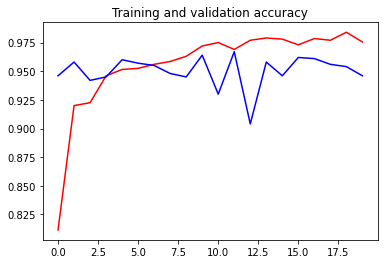

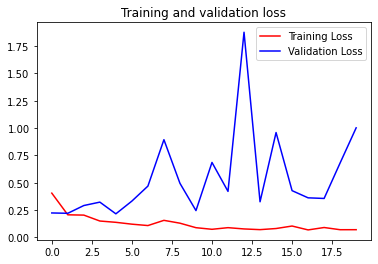

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()